In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from utils_cnn import (
    convolution,
    pooling,
    init_kernel,
    init_bias_kernel,
    convolution_multiple_kernel,
    ReLU,
    init_weights,
    init_bias,
    softmax,
    one_hot,
    cross_entropy_loss,
    calculate_cross_entropy_loss_without_softmax_value,
    derivative_ReLU,
    derivative_layer_before_max_pooling,
    derivative_layer_before_max_pooling_for_multiple_point,
    derivative_for_filter,
    derivative_for_bias_kernel,
    add_padding_multiple_point,
    add_dilation_multiple_point,
)

In [3]:
# Tải xuống dataset MNIST
(X, Y), (x_test, y_test) = mnist.load_data()

# Kiểm tra kích thước của dữ liệu
print("Training data shape:", X.shape)  # (60000, 28, 28)
print("Testing data shape:", x_test.shape)    # (10000, 28, 28)

Training data shape: (60000, 28, 28)
Testing data shape: (10000, 28, 28)


In [4]:
len(X)

60000

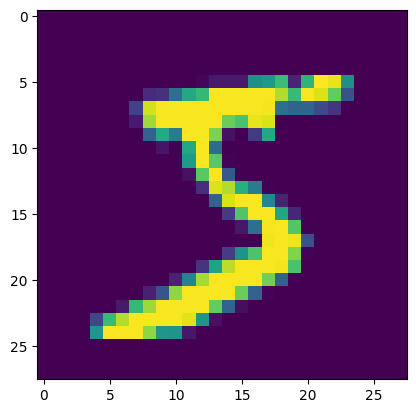

In [5]:
plt.imshow(X[0])

In [6]:
Y[0]

5

In [7]:
def forward_cnn(X: np.ndarray, Y: np.ndarray):
    """

    Args:
        X (np.ndarray): X is matrix with shape (K, N)
        Y (np.ndarray): Y is matrix with shape (C, N)
        
        K: size of K depend on the last layer of Convolution layer.
        N: is number of training points.


    """
    N = X.shape[0]
    
    # Init value for convolution layers
    K_11 = init_kernel((5, 5)) # Kernel 11 
    K_12 = init_kernel((5, 5)) # Kernel 12
    bk_11 = init_bias_kernel() # Bias kernel 11
    bk_12 = init_bias_kernel() # Bias kernel 12
    sk_1 = 1 # Stride kernel 1
    sp_1 = 2 # Stride pool 1
    size_pool_1 = (2, 2) # Size of pooling 1
    
    K_21 = init_kernel((3, 3, 2)) # Kernel 21
    K_22 = init_kernel((3, 3, 2)) # Kernel 22
    K_23 = init_kernel((3, 3, 2)) # Kernel 23 
    K_24 = init_kernel((3, 3, 2)) # Kernel 24
    bk_21 = init_bias_kernel() # Bias kernel 21
    bk_22 = init_bias_kernel() # Bias kernel 22
    bk_23 = init_bias_kernel() # Bias kernel 23
    bk_24 = init_bias_kernel() # Bias kernel 24
    sk_2 = 1 # Stride kernel 2
    sp_2 = 2 # Stride pool 2
    size_pool_2 = (2, 2) # Size of pooling 1
    
    Zk_1_size = [24, 24, 2]
    list_Zk_1 = np.zeros([N] + Zk_1_size)
    C_1_size = [24, 24, 2]
    list_C_1 = np.zeros([N] + C_1_size)
    P_1_size = [12, 12, 2]
    list_P_1 = np.zeros([N] + P_1_size)
    
    Zk_2_size = [10, 10, 4]
    list_Zk_2 = np.zeros([N] + Zk_2_size)
    C_2_size = [10, 10, 4]
    list_C_2 = np.zeros([N] + C_2_size)
    P_2_size = [5, 5, 4]
    list_P_2 = np.zeros([N] + P_2_size)
    
    # Init value for fully connected layers
    A_0 = np.zeros((np.prod(P_2_size), N))
    
    W_1 = init_weights((100, 100))
    b_1 = init_bias((100, 1))
    
    W_2 = init_weights((100, 100))
    b_2 = init_bias((100, 1))
    
    W_3 = init_weights((100, 10))
    b_3 = init_bias((10, 1))
        
    
    # Calculate for kernel layers and input A_0 for fully connected layres
    for i, x in enumerate(X):        
        Zk_1 = convolution_multiple_kernel(x, (K_11, K_12), (bk_11, bk_12), sk_1)
        C_1 = ReLU(Zk_1)
        P_1 = pooling(C_1, size_pool_1, stride=sp_1)
        
        Zk_2 = convolution_multiple_kernel(P_1, (K_21, K_22, K_23, K_24), (bk_21, bk_22, bk_23, bk_24), sk_2)
        C_2 = ReLU(Zk_2)
        P_2 = pooling(C_2, size_pool_2, stride=sp_2)
        
        list_Zk_1[i] = Zk_1
        list_C_1[i] = C_1
        list_P_1[i] = P_1
        
        list_Zk_2[i] = Zk_2
        list_C_2[i] = C_2
        list_P_2[i] = P_2
        
        A_0[:, i] = P_2.flatten()
    
    # Calculate for fully connected layers
    Z_1 = W_1.T.dot(A_0) + b_1
    A_1 = ReLU(Z_1)
    
    Z_2 = W_2.T.dot(A_1) + b_2
    A_2 = ReLU(Z_2)
    
    Z_3 = W_3.T.dot(A_2) + b_3
    A_3 = softmax(Z_3) # This is prediction output
    
    # calculate loss value by cross entropy
    loss = calculate_cross_entropy_loss_without_softmax_value(Y, Z_3)
    
    # Backpropagation for fully connected layers
    lr = 0.001
    
    E_3 = 1/N * (Y - A_3)
    dL_dW_3 = A_2.dot(E_3.T)
    dL_db_3 = np.sum(E_3, axis=1)
    
    E_2 = W_3.dot(E_3) * derivative_ReLU(Z_2)
    dL_dW_2 = A_1.dot(E_2.T)
    dL_db_2 = np.sum(E_2, axis=1)
    
    E_1 = W_2.dot(E_2) * derivative_ReLU(Z_1)
    dL_dW_1 = A_0.dot(E_1.T)
    dL_db_1 = np.sum(E_1, axis=1)
    
    # Backpropagation for kernel layers
    
    # Number of rows in dL_dP_2 = number of columns in dL_dA_0 = N
    # We loop through the columns of dL_dA_0 (respectively for each point data in X) and reshape it to size of P_2 and set that value in dL_dP_2
    dL_dA_0: np.ndarray = W_1.dot(E_1)
    list_dL_dP_2 = np.zeros([N] + P_2_size)
    
    for i in range(N):
        list_dL_dP_2[i] = dL_dA_0[:, i].reshape(P_2_size)

    list_dL_dC_2 = derivative_layer_before_max_pooling_for_multiple_point(list_C_2, list_P_2, list_dL_dP_2, size_pool_2, sp_2)
    list_dL_dZk_2 = list_dL_dC_2 * derivative_ReLU(list_Zk_2)
    
    dL_dK_21 = derivative_for_filter(list_P_1, list_dL_dZk_2[:, :, :, 0], K_21.shape)
    dL_dK_22 = derivative_for_filter(list_P_1, list_dL_dZk_2[:, :, :, 1], K_22.shape)
    dL_dK_23 = derivative_for_filter(list_P_1, list_dL_dZk_2[:, :, :, 2], K_23.shape)
    dL_dK_24 = derivative_for_filter(list_P_1, list_dL_dZk_2[:, :, :, 3], K_24.shape)
    
    dL_bk_21 = derivative_for_bias_kernel(list_dL_dZk_2[:, :, :, 0])
    dL_bk_22 = derivative_for_bias_kernel(list_dL_dZk_2[:, :, :, 1])
    dL_bk_23 = derivative_for_bias_kernel(list_dL_dZk_2[:, :, :, 2])
    dL_bk_24 = derivative_for_bias_kernel(list_dL_dZk_2[:, :, :, 3])
    
    return dL_bk_21, dL_bk_22, dL_bk_23, dL_bk_24
    
    

In [8]:
dL_bk_21, dL_bk_22, dL_bk_23, dL_bk_24 = forward_cnn(X[0:300], one_hot(Y[0:300]))

In [2]:
import numpy as np

def rotate_matrix_180_row(X):
    output_rotate_row = np.zeros(X.shape)
    
    number_X_row = X.shape[0]
    
    first_row_run = 0
    last_row_run = number_X_row - 1
    while first_row_run < number_X_row:
        output_rotate_row[first_row_run, :] = X[last_row_run, :]
        
        first_row_run += 1
        last_row_run -= 1
        
    return output_rotate_row

def rotate_matrix_180_col(X: np.ndarray):
    output_rotate_col = np.zeros(X.shape)
    
    number_X_col = X.shape[1]
    
    first_col_run = 0
    last_col_run = number_X_col - 1
    while first_col_run < number_X_col:
        output_rotate_col[:, first_col_run] = X[:, last_col_run]
        
        first_col_run += 1
        last_col_run -= 1
        
    return output_rotate_col


def rotate_matrix_180(X):
    return rotate_matrix_180_col(rotate_matrix_180_row(X))

In [3]:
X = np.random.randint(1, 10, (3, 2))

In [8]:
X.reshape((3, 2, 1))[:,:,0]

array([[5, 6],
       [6, 2],
       [1, 3]])

In [7]:
X

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [6]:
X

array([[5, 6],
       [6, 2],
       [1, 3]])